In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from photoz_utils import *
from photoz_plots import *

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
z_max = 2.5
sample_array = "[1, 1, 1, 1]"
sampling_method = 'oversampled'

if sampling_method == 'control':
    train_array = pd.read_csv('/data/HSC/HSC_v6/3_model_comparison/'+str(sampling_method)+'_training_set_'+str(z_max)+'z#1.csv')
else:
    train_array = pd.read_csv('/data/HSC/HSC_v6/3_model_comparison/'+str(sampling_method)+'_training_set_'+str(z_max)+'z_'+str(sample_array)+'#1.csv')

train_array = np.asarray(train_array)

test_array = pd.read_csv('/data/HSC/HSC_v6/3_model_comparison/testing_'+str(z_max)+'z_.csv')
test_array = np.asarray(test_array)

In [4]:
OID_test = test_array[:,0]
X_test = test_array[:,[12,13,14,15,16]]
y_test = test_array[:,2]

In [5]:
X_train = np.asarray(train_array[:,[12,13,14,15,16]])
y_train = np.asarray(train_array[:,2])
scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 1.3497895 ,  1.56114542,  1.90724162,  1.90576495,  0.05111944],
       [-1.42890146, -1.77927869, -1.89740555, -1.9457974 , -0.03542788],
       [-0.02110389, -0.61243851, -0.85133626, -0.9071514 , -0.01264783],
       ...,
       [-0.74125701, -0.43963081, -0.3714111 , -0.289177  ,  0.00280278],
       [ 1.46152195,  1.558714  ,  1.59625455,  1.41483623,  0.03583944],
       [ 0.36277458,  0.43307466,  0.25656257,  0.33317727,  0.0159998 ]])

In [6]:
len(X_train)

629940

In [7]:
rand_forest_model = RandomForestRegressor(n_estimators=200)
rand_forest_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

In [8]:
y_pred = np.ravel(rand_forest_model.predict(X_test))

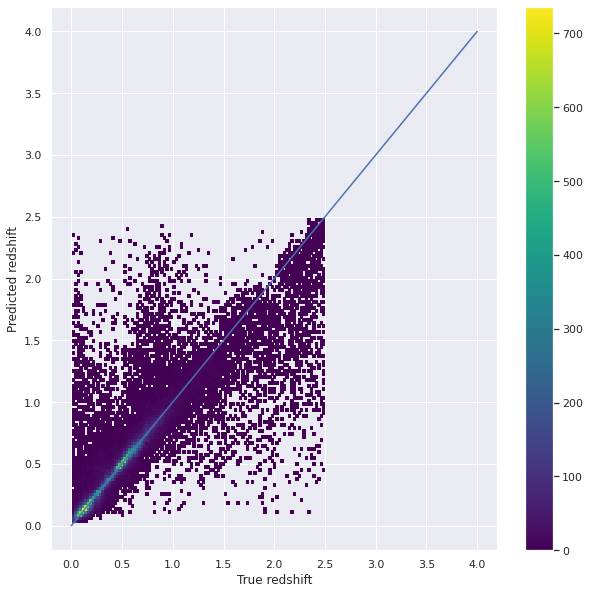

In [9]:
plot_predictions(y_pred, y_test)

In [10]:
rf_predictions = np.transpose(np.vstack((OID_test, y_test, y_pred)))

df = pd.DataFrame(rf_predictions, columns=['object_id', 'specz_redshift', 'photoz_redshift'])
model_name = 'random_forest_v1'
metrics = get_point_metrics(pd.Series(y_pred), pd.Series(y_test), 2.5, binned=False)

if os.path.exists(f'/predictions/HSC_v6_sampling_method_models/{model_name}') == False:
    os.makedirs(f'/predictions/HSC_v6_sampling_method_models/{model_name}')
if sampling_method == 'control':
    df.to_csv(f'/predictions/HSC_v6_sampling_method_models/{model_name}/{sampling_method}_{z_max}z_predictions.csv', index=False)
    metrics.to_csv(f'/predictions/HSC_v6_sampling_method_models/{model_name}/{sampling_method}_{z_max}z_metrics.csv', index=False)
else:
    df.to_csv(f'/predictions/HSC_v6_sampling_method_models/{model_name}/{sampling_method}_{z_max}z_predictions_{sample_array}.csv', index=False)
    metrics.to_csv(f'/predictions/HSC_v6_sampling_method_models/{model_name}/{sampling_method}_{z_max}z_metrics_{sample_array}.csv', index=False)